In [1]:
!pip install gdown

In [2]:
import gdown

file_id = '1QEYdxoVGH_-BWUpeVDSXX5jpKAqMzzCQ'
url = f'https://drive.google.com/uc?id={file_id}'

# Esto descarga el archivo CSV grande correctamente
gdown.download(url, 'US_Accidents_2016-18.csv', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1QEYdxoVGH_-BWUpeVDSXX5jpKAqMzzCQ
From (redirected): https://drive.google.com/uc?id=1QEYdxoVGH_-BWUpeVDSXX5jpKAqMzzCQ&confirm=t&uuid=6e739c2c-79bc-423d-85a0-e24ce5d2ca10
To: /content/US_Accidents_2016-18.csv
100%|██████████| 749M/749M [00:09<00:00, 75.3MB/s]


'US_Accidents_2016-18.csv'

In [3]:
%pip install pyspark

In [4]:
import pandas as pd
import numpy as np
import pyspark as spark

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, to_date

spark = SparkSession.builder.appName("Accidentes").getOrCreate()

# Leer CSV
df = spark.read.csv("US_Accidents_2016-18.csv", header=True)

#Pasamos las columnas Start_time a sólo la fecha para manejarla mejor. End_Time no nos interesa
df = df.withColumn("Date", to_date("Start_Time"))

df.show(5)

+---+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+----------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Cond

In [6]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: string (nullable = true)
 |-- Start_Time: string (nullable = true)
 |-- End_Time: string (nullable = true)
 |-- Start_Lat: string (nullable = true)
 |-- Start_Lng: string (nullable = true)
 |-- End_Lat: string (nullable = true)
 |-- End_Lng: string (nullable = true)
 |-- Distance(mi): string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: string (nullable = true)
 |-- Temperature(F): string (nullable = true)
 |-- Wind_Chill(F): string (nullable = true)
 |-- Humidity(%): string (nullable = true)
 |-- Pressure(in): string (nullable = true)
 |-- Visibility(

In [7]:
print("Cantidad de datos: ", df.count())

Cantidad de datos:  2021537


In [8]:
from pyspark.sql.functions import col, sum

df.select([
    sum(col(c).isNull().cast("int")).alias(c)
    for c in df.columns
]).show(truncate=False)

+---+------+--------+----------+--------+---------+---------+-------+-------+------------+-----------+------+----+------+-----+-------+-------+--------+------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+----+
|ID |Source|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|Description|Street|City|County|State|Zipcode|Country|Timezone|Airport_Code|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical

In [9]:
from pyspark.sql import SparkSession
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

df_clean = df.drop("ID","Source","Start_Time","End_Time","Description","Street","City","County","Zipcode","State","Country","Timezone","Airport_Code","Weather_Timestamp")
df_clean = df_clean.dropna()

categorical_cols = ["Wind_Direction","Weather_Condition", "Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit", "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming", "Traffic_Signal", "Turning_Loop", "Sunrise_Sunset", "Civil_Twilight", "Nautical_Twilight", "Astronomical_Twilight"]

indexers = [
    StringIndexer(inputCol=col, outputCol=col + "_Index", handleInvalid="keep")
    for col in categorical_cols
]

pipeline = Pipeline(stages=indexers)
model = pipeline.fit(df_clean)
df_clean = model.transform(df_clean)

df_clean = df_clean.drop(*categorical_cols)

In [10]:
accidents_per_day = df_clean.groupBy("Date").count().withColumnRenamed("count", "Accidents")

df_clean = df_clean.join(accidents_per_day, on="Date", how="left")
df_clean = df_clean.drop("Start_Time")
df_clean = df_clean.drop("Date")

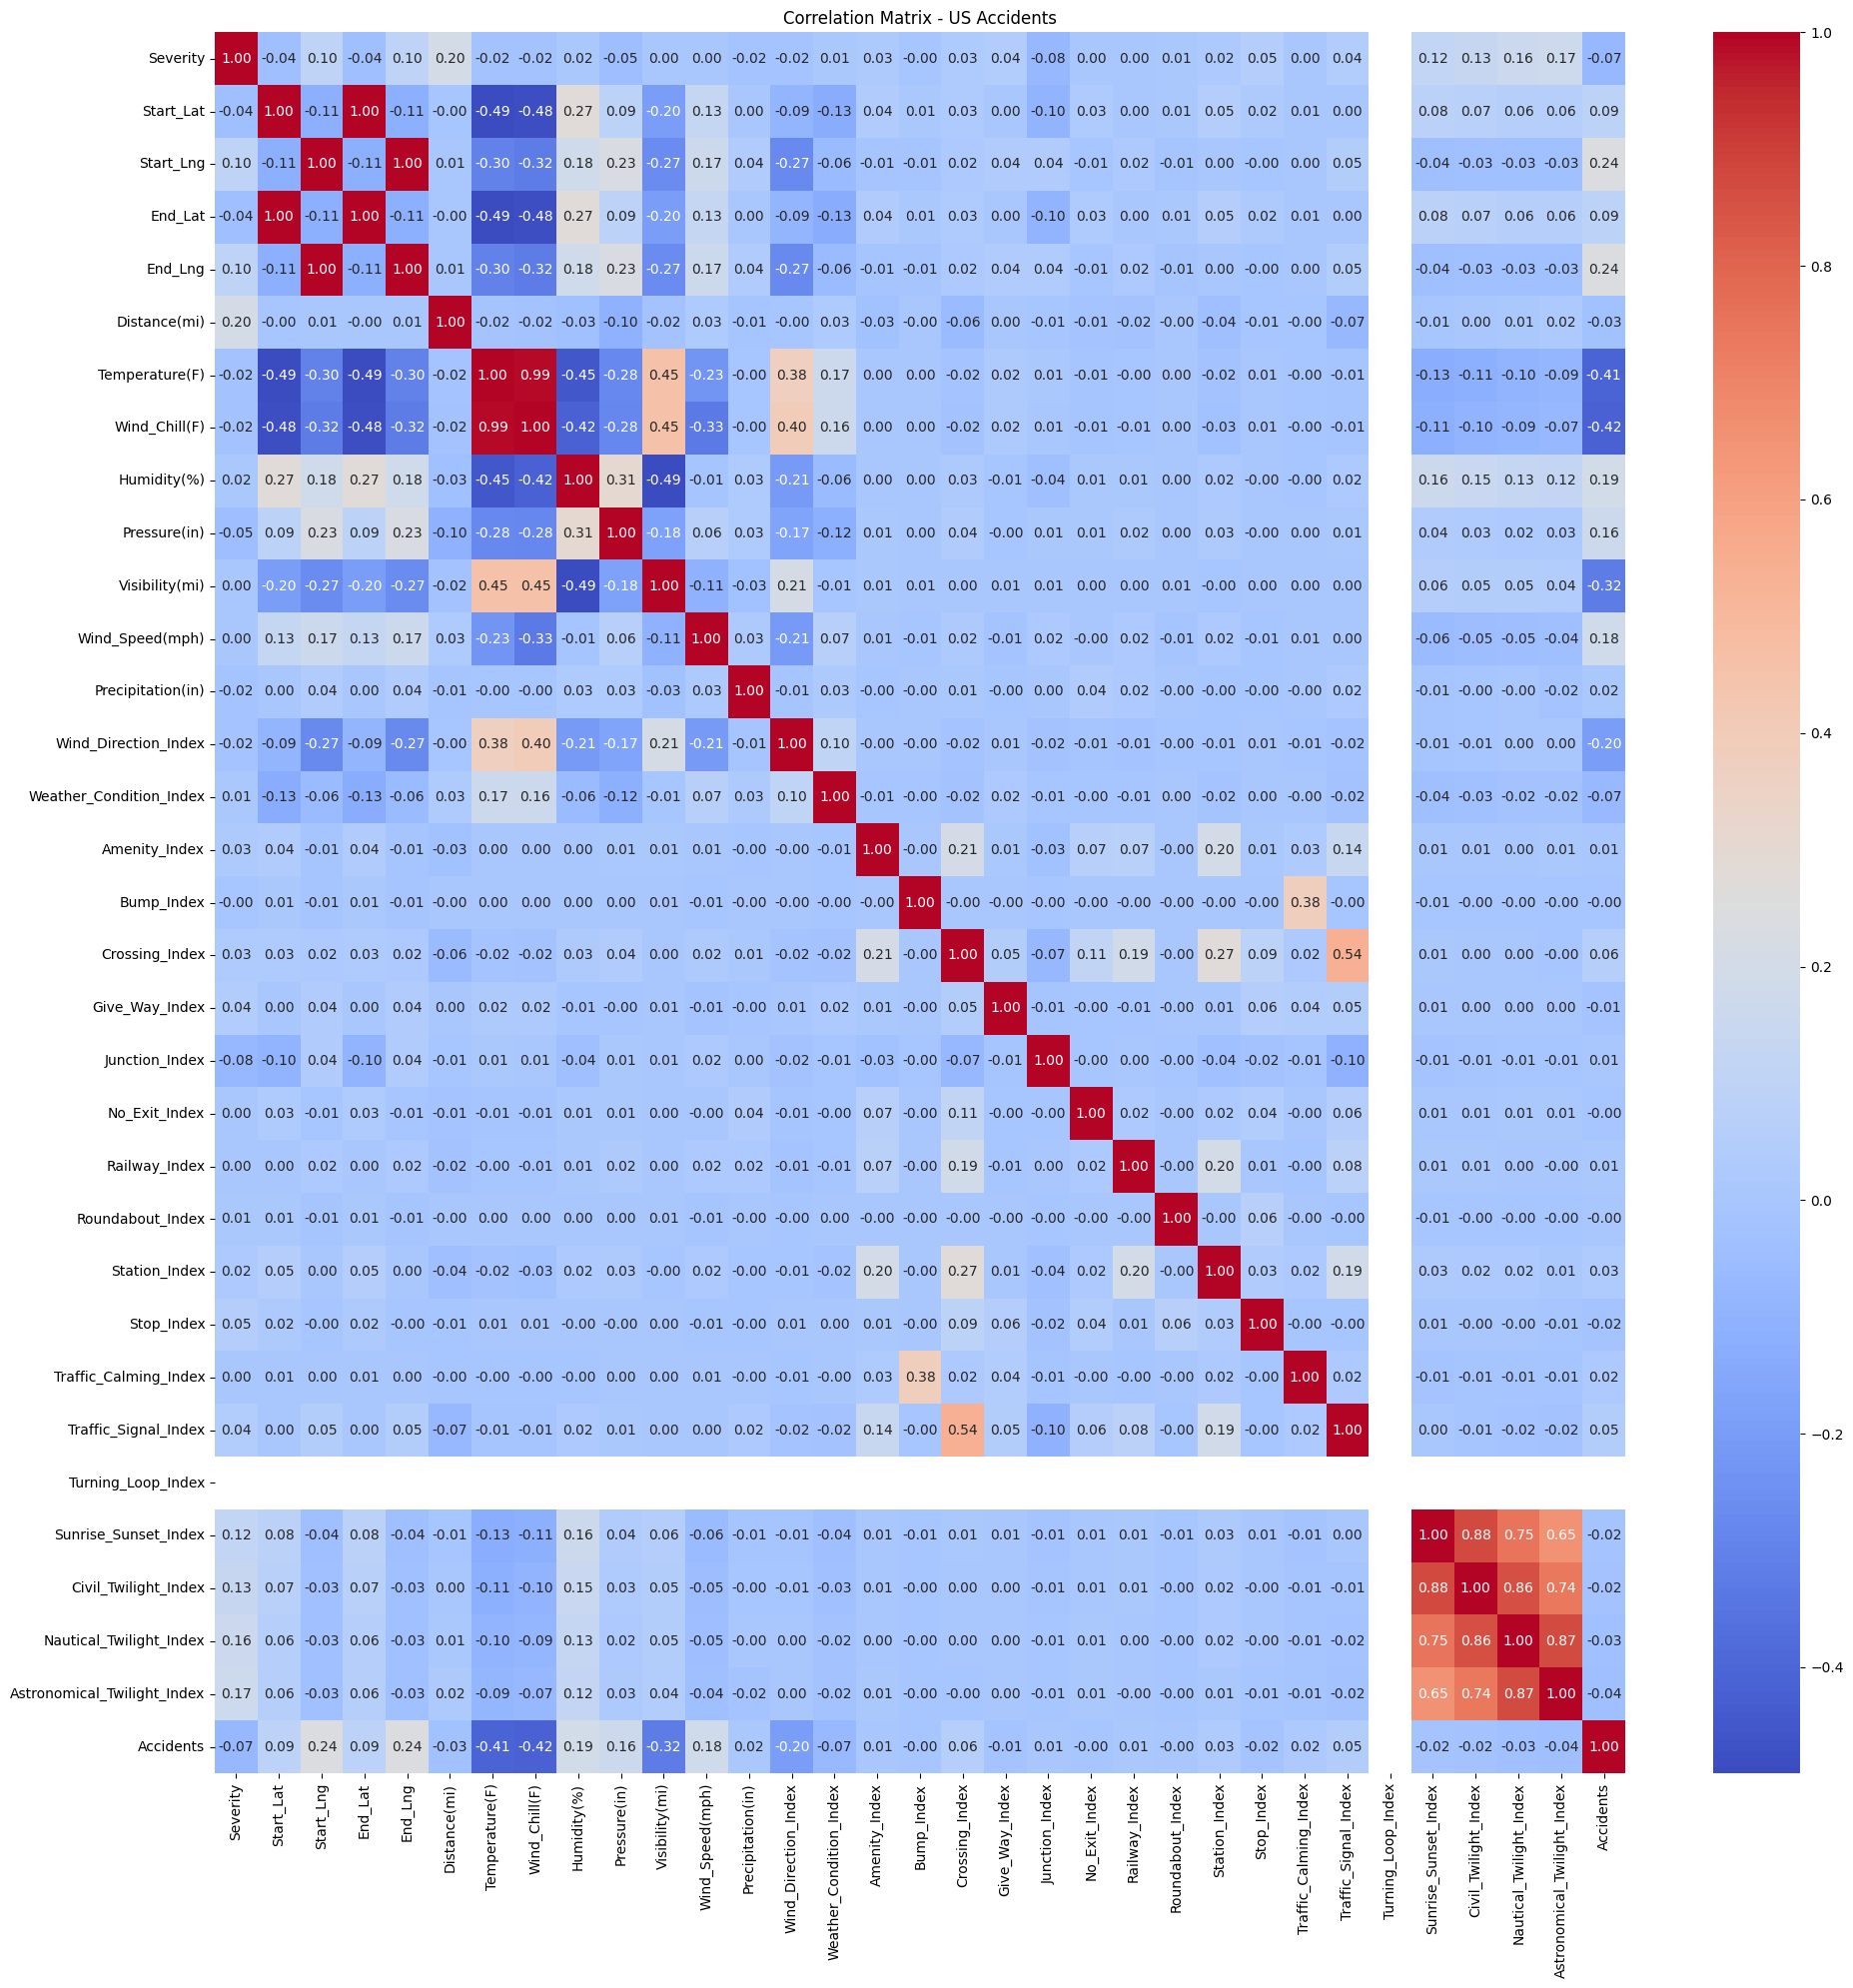

In [11]:
pdf = df_clean.toPandas()

corr_matrix = pdf.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix - US Accidents")
plt.tight_layout()
plt.show()

In [12]:
df_interest = df.select("Date", "City", "State", "Temperature(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "Wind_Direction", "Weather_Condition")

In [13]:
df_interest = df_interest.dropna()
print("Cantidad de datos: ", df_interest.count())

Cantidad de datos:  1621127


In [14]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

categorical_cols = ["City", "State", "Wind_Direction","Weather_Condition"]

indexers = [
    StringIndexer(inputCol=col, outputCol=col + "_Index", handleInvalid="keep")
    for col in categorical_cols
]

pipeline = Pipeline(stages=indexers)
model = pipeline.fit(df_interest)
df_interest = model.transform(df_interest)

In [15]:
df_interest.show(5)

+----------+------------+-----+--------------+-----------+------------+--------------+---------------+--------------+-----------------+----------+-----------+--------------------+-----------------------+
|      Date|        City|State|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Wind_Direction|Weather_Condition|City_Index|State_Index|Wind_Direction_Index|Weather_Condition_Index|
+----------+------------+-----+--------------+-----------+------------+--------------+---------------+--------------+-----------------+----------+-----------+--------------------+-----------------------+
|2016-02-08|Williamsburg|   OH|          36.0|      100.0|       29.67|          10.0|            3.5|            SW|         Overcast|     885.0|       12.0|                 6.0|                    1.0|
|2016-02-08|      Dayton|   OH|          35.1|       96.0|       29.64|           9.0|            4.6|            SW|    Mostly Cloudy|      26.0|       12.0|                 6.0|     

In [16]:
accidents_per_day = df_interest.groupBy("Date").count().withColumnRenamed("count", "Accidents")

df_accidents_daily = df_interest.join(accidents_per_day, on="Date", how="left")
df_accidents_daily = df_accidents_daily.drop("Start_Time")

df_accidents_daily.show(5)

+----------+------------+-----+--------------+-----------+------------+--------------+---------------+--------------+-----------------+----------+-----------+--------------------+-----------------------+---------+
|      Date|        City|State|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Wind_Direction|Weather_Condition|City_Index|State_Index|Wind_Direction_Index|Weather_Condition_Index|Accidents|
+----------+------------+-----+--------------+-----------+------------+--------------+---------------+--------------+-----------------+----------+-----------+--------------------+-----------------------+---------+
|2016-02-08|Williamsburg|   OH|          36.0|      100.0|       29.67|          10.0|            3.5|            SW|         Overcast|     885.0|       12.0|                 6.0|                    1.0|       49|
|2016-02-08|      Dayton|   OH|          35.1|       96.0|       29.64|           9.0|            4.6|            SW|    Mostly Cloudy|      26.

In [17]:
from pyspark.sql.functions import avg

df_interest_countrywise = df_accidents_daily.groupBy("Date").agg(
    avg("Temperature(F)").alias("Temperature(F)"),
    avg("Humidity(%)").alias("Humidity(%)"),
    avg("Pressure(in)").alias("Pressure(in)"),
    avg("Visibility(mi)").alias("Visibility(mi)"),
    avg("Wind_Speed(mph)").alias("Wind_Speed(mph)"),
    avg("Wind_Direction_Index").alias("Wind_Direction_Index"),
    avg("Weather_Condition_Index").alias("Weather_Condition_Index"),
    avg("Accidents").alias("Accidents")
)

df_interest_countrywise = df_interest_countrywise.orderBy("Date")
df_interest_countrywise.show(5)

+----------+------------------+-----------------+------------------+------------------+------------------+--------------------+-----------------------+---------+
|      Date|    Temperature(F)|      Humidity(%)|      Pressure(in)|    Visibility(mi)|   Wind_Speed(mph)|Wind_Direction_Index|Weather_Condition_Index|Accidents|
+----------+------------------+-----------------+------------------+------------------+------------------+--------------------+-----------------------+---------+
|2016-01-14|              31.0|             69.0|             29.53|              10.0|               3.0|                20.0|                    9.0|      7.0|
|2016-02-08|35.355102040816305|91.71428571428571| 29.64163265306123|6.7306122448979595|  6.36326530612245|   4.918367346938775|     3.5714285714285716|     49.0|
|2016-02-09|23.532203389830517|87.11864406779661|29.679830508474573| 2.410169491525424|11.461016949152546|   5.661016949152542|      5.728813559322034|     59.0|
|2016-02-10|17.8543478260869

In [18]:
from pyspark.sql.functions import year

# DataFrame para 2016 y 2017
df_countrywise_16_17 = df_interest_countrywise.filter(year("Date").isin([2016, 2017]))

# DataFrame para 2018
df_countrywise_18 = df_interest_countrywise.filter(year("Date") == 2018)

In [19]:
df_countrywise_16_17.show(5)
print("--------------------------------------")
print("--------------------------------------")
df_countrywise_18.show(5)

+----------+------------------+-----------------+------------------+------------------+------------------+--------------------+-----------------------+---------+
|      Date|    Temperature(F)|      Humidity(%)|      Pressure(in)|    Visibility(mi)|   Wind_Speed(mph)|Wind_Direction_Index|Weather_Condition_Index|Accidents|
+----------+------------------+-----------------+------------------+------------------+------------------+--------------------+-----------------------+---------+
|2016-01-14|              31.0|             69.0|             29.53|              10.0|               3.0|                20.0|                    9.0|      7.0|
|2016-02-08|35.355102040816305|91.71428571428571| 29.64163265306123|6.7306122448979595|  6.36326530612245|   4.918367346938775|     3.5714285714285716|     49.0|
|2016-02-09|23.532203389830517|87.11864406779661|29.679830508474573| 2.410169491525424|11.461016949152546|   5.661016949152542|      5.728813559322034|     59.0|
|2016-02-10|17.8543478260869

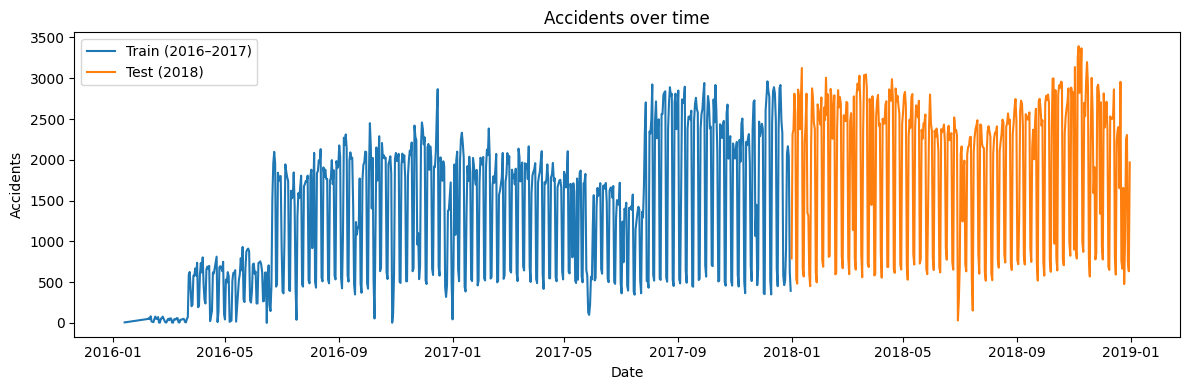

In [20]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date
import pandas as pd

# Aseguramos que la columna 'Date' sea tipo fecha
df_16_17 = df_countrywise_16_17.withColumn("Date", to_date("Date")).select("Date", "Accidents").orderBy("Date")
df_18 = df_countrywise_18.withColumn("Date", to_date("Date")).select("Date", "Accidents").orderBy("Date")

# Usamos collect() para traer los datos a listas
data_16_17 = df_16_17.collect()
data_18 = df_18.collect()

# Extraemos listas de fechas y valores
dates_16_17 = [row["Date"] for row in data_16_17]
accidents_16_17 = [row["Accidents"] for row in data_16_17]

dates_18 = [row["Date"] for row in data_18]
accidents_18 = [row["Accidents"] for row in data_18]

# Graficamos
plt.figure(figsize=(12, 4))
plt.plot(dates_16_17, accidents_16_17, label="Train (2016–2017)")
plt.plot(dates_18, accidents_18, label="Test (2018)")
plt.legend()
plt.title("Accidents over time")
plt.xlabel("Date")
plt.ylabel("Accidents")
plt.tight_layout()
plt.show()

In [21]:
# Creando X_train y Y_train Usando Pandas
df_ordered = df_countrywise_16_17.orderBy("Date")

pdf = df_ordered.toPandas()

# Extraemos las columnas numéricas y el numero de accidentes
cols = ["Temperature(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "Wind_Direction_Index", "Weather_Condition_Index", "Accidents"]

dias = 7
X, y = [], []
for i in range(len(pdf) - dias):
    X.append(pdf.loc[i:i+dias-1, cols].values)  # ventana 7 días
    y.append(pdf.loc[i+dias, "Accidents"])      # día 8

X_train, Y_train = np.array(X), np.array(y)

In [22]:
# Creando X_train y Y_train sin Pandas

# Seleccionamos solo las columnas necesarias y las pasamos a numpy
selected_cols = ["Temperature(F)", "Humidity(%)", "Pressure(in)",
                 "Visibility(mi)", "Wind_Speed(mph)", "Wind_Direction_Index", "Weather_Condition_Index", "Accidents"]

df_ordered = df_countrywise_16_17.orderBy("Date")

# Convertimos a un NumPy array (ordenado previamente)
data_np = np.array(df_ordered.select(selected_cols).collect())

# Ventana deslizante
X_train = []
Y_train = []
dias = 7

for i in range(len(data_np) - dias):
    X_train.append(data_np[i:i+dias])       # 7 días de features
    Y_train.append(data_np[i+dias, -1])     # accidentes del día siguiente

X_train = np.array(X_train)  # shape: (num_samples, 7, 7)
Y_train = np.array(Y_train)  # shape: (num_samples,)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

X_train shape: (683, 7, 8)
Y_train shape: (683,)


In [23]:
# Creando X_test y Y_test sin Pandas

# Seleccionamos solo las columnas necesarias y las pasamos a numpy
selected_cols = ["Temperature(F)", "Humidity(%)", "Pressure(in)",
                 "Visibility(mi)", "Wind_Speed(mph)", "Wind_Direction_Index", "Weather_Condition_Index", "Accidents"]

df_ordered = df_countrywise_18.orderBy("Date")

# Convertimos a un NumPy array (ordenado previamente)
data_np = np.array(df_ordered.select(selected_cols).collect())

X_test = []
Y_test = []
dias = 7

for i in range(len(data_np) - dias):
    X_test.append(data_np[i:i+dias])       # 7 días de features
    Y_test.append(data_np[i+dias, -1])

X_test  = np.array(X_test)  # shape: (num_samples, 7, 7)
Y_test  = np.array(Y_test)  # shape: (num_samples,)

print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_test shape: (358, 7, 8)
Y_test shape: (358,)


Ahora vamos a entrenar un regresor de XGboost.

In [24]:
!pip install xgboost

In [25]:
import xgboost as xgb

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

model_countrywise = xgb.XGBRegressor()
model_countrywise.fit(X_train_flat, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = model_countrywise.predict(X_test_flat)

mse = mean_squared_error(Y_test, y_pred)
mae = mean_absolute_error(Y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 317270.10
MAE: 382.90


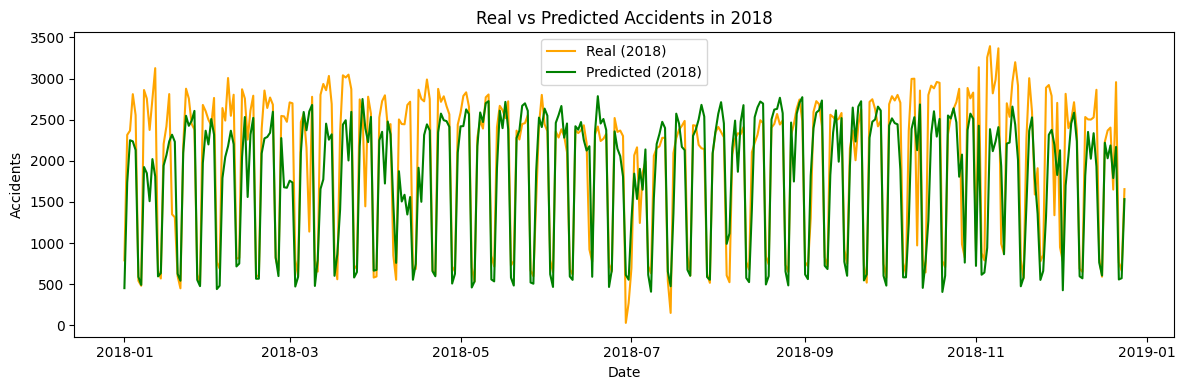

In [27]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date
import pandas as pd

# Asegurar que la columna Date esté en formato fecha y ordenar
df_dates_18 = df_countrywise_18.select("Date", "Accidents").orderBy("Date")

# Obtener los datos como listas
rows_18 = df_dates_18.collect()
dates_18 = [row["Date"] for row in rows_18]
real_accidents_18 = [row["Accidents"] for row in rows_18]

# Validar que las predicciones coincidan en longitud
if len(real_accidents_18) != len(y_pred):
    # Truncar los valores reales y fechas a la longitud de y_pred
    dates_18 = dates_18[:len(y_pred)]
    real_accidents_18 = real_accidents_18[:len(y_pred)]

# Graficar los resultados
plt.figure(figsize=(12, 4))
plt.plot(dates_18, real_accidents_18, label="Real (2018)", color="orange")
plt.plot(dates_18, y_pred, label="Predicted (2018)", color="green")
plt.title("Real vs Predicted Accidents in 2018")
plt.xlabel("Date")
plt.ylabel("Accidents")
plt.legend()
plt.tight_layout()
plt.show()

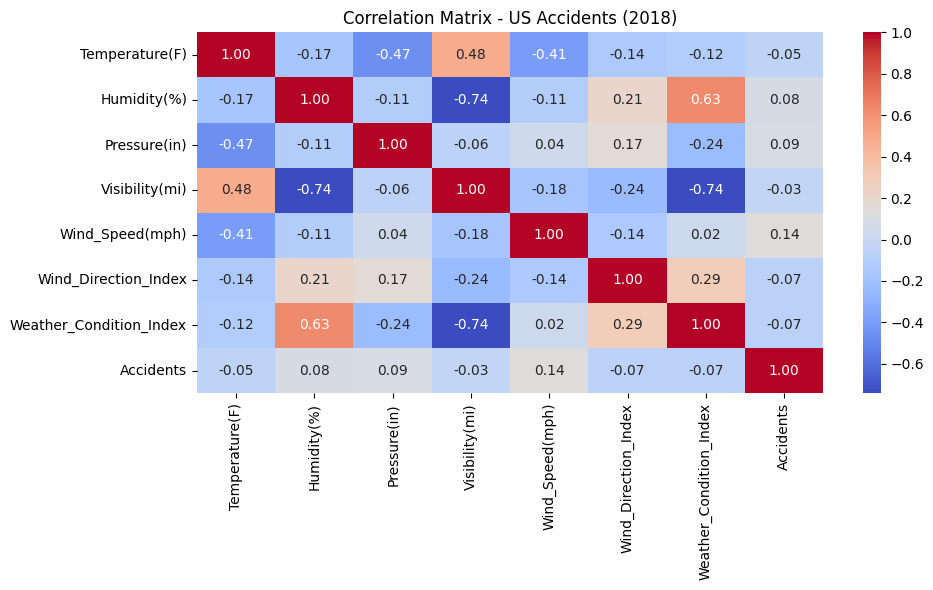

In [28]:
from pyspark.sql import SparkSession
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que ya tienes df_countrywise_18
selected_columns = ["Temperature(F)", "Humidity(%)", "Pressure(in)",
                    "Visibility(mi)", "Wind_Speed(mph)", "Wind_Direction_Index", "Weather_Condition_Index", "Accidents"]

# Convertir a pandas
pdf = df_countrywise_18.select(selected_columns).toPandas()

# Calcular matriz de correlación
corr_matrix = pdf.corr()

# Visualizar con seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix - US Accidents (2018)")
plt.tight_layout()
plt.show()

Vamos a observar los accidentes en sólo algunos estados

In [29]:
df_Cali = df_interest.filter(df_interest["State"] == "CA")
df_Texas = df_interest.filter(df_interest["State"] == "TX")
df_Florida = df_interest.filter(df_interest["State"] == "FL")
df_New_York = df_interest.filter(df_interest["State"] == "NY")
df_Penny = df_interest.filter(df_interest["State"] == "PA")

Empezemos por California

In [30]:
df_Cali = df_Cali.orderBy("Date")

accidents_per_day = df_Cali.groupBy("Date").count().withColumnRenamed("count", "Accidents")

df_Cali = df_Cali.join(accidents_per_day, on="Date", how="left")

df_Cali.show(5)

+----------+------------+-----+--------------+-----------+------------+--------------+---------------+--------------+-----------------+----------+-----------+--------------------+-----------------------+---------+
|      Date|        City|State|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Wind_Direction|Weather_Condition|City_Index|State_Index|Wind_Direction_Index|Weather_Condition_Index|Accidents|
+----------+------------+-----+--------------+-----------+------------+--------------+---------------+--------------+-----------------+----------+-----------+--------------------+-----------------------+---------+
|2016-06-21|     Vallejo|   CA|          75.0|       48.0|        30.0|          10.0|            5.8|      Variable|            Clear|     168.0|        0.0|                 4.0|                    0.0|      477|
|2016-06-21|     Hayward|   CA|          75.0|       48.0|       30.06|          10.0|            4.6|           WSW|            Clear|      66.

In [31]:
df_Cali = df_Cali.groupBy("Date").agg(
    avg("Temperature(F)").alias("Temperature(F)"),
    avg("Humidity(%)").alias("Humidity(%)"),
    avg("Pressure(in)").alias("Pressure(in)"),
    avg("Visibility(mi)").alias("Visibility(mi)"),
    avg("Wind_Speed(mph)").alias("Wind_Speed(mph)"),
    avg("Wind_Direction_Index").alias("Wind_Direction_Index"),
    avg("Weather_Condition_Index").alias("Weather_Condition_Index"),
    avg("Accidents").alias("Accidents")
)

df_Cali = df_Cali.orderBy("Date")

In [32]:
df_Cali.show(5)

+----------+------------------+------------------+------------------+------------------+-----------------+--------------------+-----------------------+---------+
|      Date|    Temperature(F)|       Humidity(%)|      Pressure(in)|    Visibility(mi)|  Wind_Speed(mph)|Wind_Direction_Index|Weather_Condition_Index|Accidents|
+----------+------------------+------------------+------------------+------------------+-----------------+--------------------+-----------------------+---------+
|2016-03-22|57.514999999999986|             52.75| 30.13474999999999|               9.9|7.482499999999999|               5.075|                  0.275|     40.0|
|2016-03-23| 67.03071748878924|33.369955156950674|30.152757847533678|10.139013452914797|8.488565022421524|   5.598654708520179|     0.8878923766816144|    446.0|
|2016-03-24| 67.83262910798122| 42.40845070422535|30.072511737089204|10.291549295774647|8.215258215962452|   5.678403755868545|     0.7535211267605634|    426.0|
|2016-03-25| 68.215176151761

In [33]:
# DataFrame para 2016 y 2017
df_cali_16_17 = df_Cali.filter(year("Date").isin([2016, 2017]))

# DataFrame para 2018
df_cali_18 = df_Cali.filter(year("Date") == 2018)

In [34]:
# Creando X_train y Y_train sin Pandas

# Seleccionamos solo las columnas necesarias y las pasamos a numpy
selected_cols = ["Temperature(F)", "Humidity(%)", "Pressure(in)",
                 "Visibility(mi)", "Wind_Speed(mph)", "Wind_Direction_Index", "Weather_Condition_Index", "Accidents"]

df_ordered = df_cali_16_17.orderBy("Date")

# Convertimos a un NumPy array (ordenado previamente)
data_np = np.array(df_ordered.select(selected_cols).collect())

# Ventana deslizante
X_train = []
Y_train = []
dias = 7

for i in range(len(data_np) - dias):
    X_train.append(data_np[i:i+dias])       # 7 días de features
    Y_train.append(data_np[i+dias, -1])     # accidentes del día siguiente

X_train = np.array(X_train)  # shape: (num_samples, 7, 7)
Y_train = np.array(Y_train)  # shape: (num_samples,)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

X_train shape: (637, 7, 8)
Y_train shape: (637,)


In [35]:
# Creando X_test y Y_test sin Pandas

# Seleccionamos solo las columnas necesarias y las pasamos a numpy
selected_cols = ["Temperature(F)", "Humidity(%)", "Pressure(in)",
                 "Visibility(mi)", "Wind_Speed(mph)", "Wind_Direction_Index", "Weather_Condition_Index", "Accidents"]

df_ordered = df_cali_18.orderBy("Date")

# Convertimos a un NumPy array (ordenado previamente)
data_np = np.array(df_ordered.select(selected_cols).collect())

X_test = []
Y_test = []
dias = 7

for i in range(len(data_np) - dias):
    X_test.append(data_np[i:i+dias])       # 7 días de features
    Y_test.append(data_np[i+dias, -1])

X_test  = np.array(X_test)  # shape: (num_samples, 7, 7)
Y_test  = np.array(Y_test)  # shape: (num_samples,)

print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_test shape: (358, 7, 8)
Y_test shape: (358,)


In [36]:
import xgboost as xgb

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

model_Cali = xgb.XGBRegressor()
model_Cali.fit(X_train_flat, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model_Cali.predict(X_test_flat)

mse = mean_squared_error(Y_test, y_pred)
mae = mean_absolute_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

MSE: 9526.80
MAE: 69.76
R²: 0.51


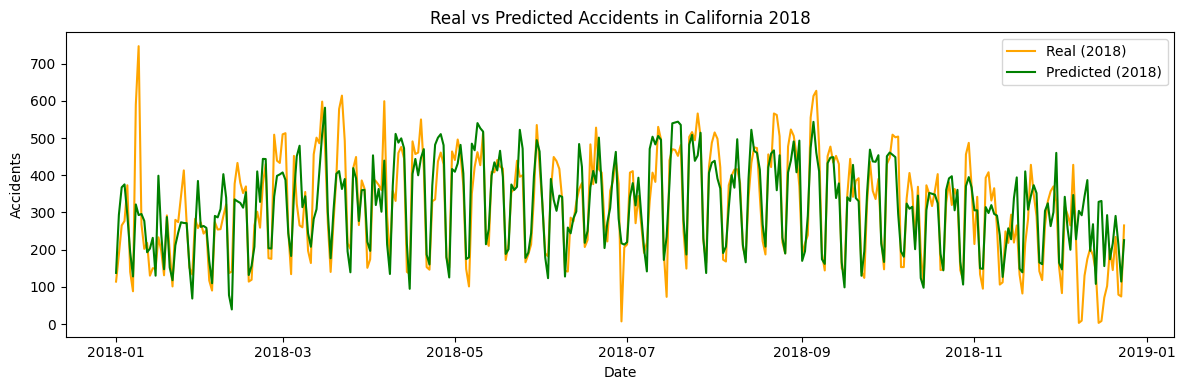

In [38]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date
import pandas as pd

# Ordenamos
df_cali_dates_18 = df_cali_18.select("Date", "Accidents").orderBy("Date")

# Obtener los datos como listas
rows_cali_18 = df_cali_dates_18.collect()
dates_cali_18 = [row["Date"] for row in rows_cali_18]
real_accidents_cali_18 = [row["Accidents"] for row in rows_cali_18]

# -------------------------------------------------

# Validar que las predicciones coincidan en longitud
if len(real_accidents_cali_18) != len(y_pred):
    # Truncar los valores reales y fechas a la longitud de y_pred
    dates_cali_18 = dates_cali_18[:len(y_pred)]
    real_accidents_cali_18 = real_accidents_cali_18[:len(y_pred)]

# Graficar los resultados
plt.figure(figsize=(12, 4))
plt.plot(dates_cali_18, real_accidents_cali_18, label="Real (2018)", color="orange")
plt.plot(dates_cali_18, y_pred, label="Predicted (2018)", color="green")
plt.title("Real vs Predicted Accidents in California 2018")
plt.xlabel("Date")
plt.ylabel("Accidents")
plt.legend()
plt.tight_layout()
plt.show()

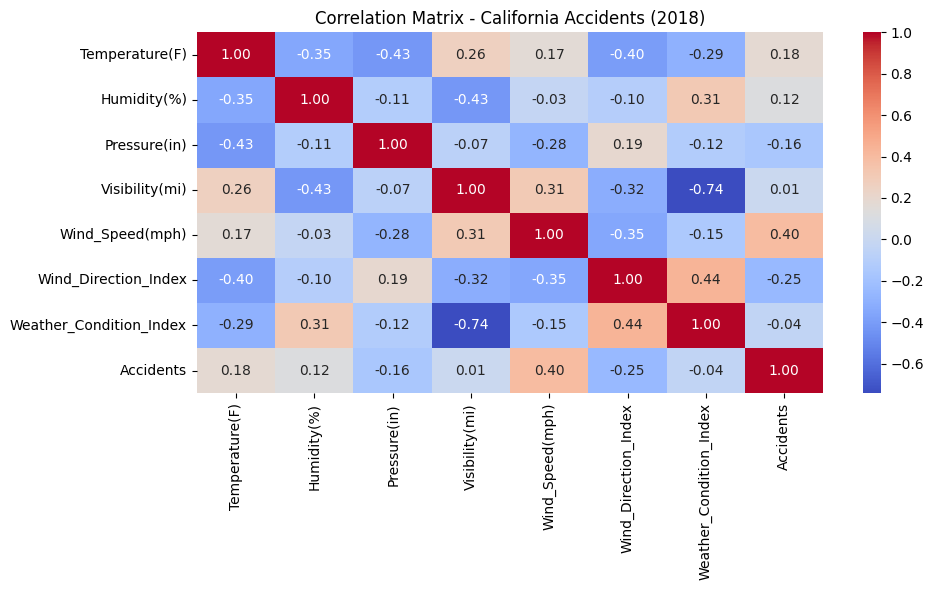

In [39]:
from pyspark.sql import SparkSession
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que ya tienes df_countrywise_18
selected_columns = ["Temperature(F)", "Humidity(%)", "Pressure(in)",
                    "Visibility(mi)", "Wind_Speed(mph)", "Wind_Direction_Index", "Weather_Condition_Index", "Accidents"]

# Convertir a pandas
pdf = df_cali_18.select(selected_columns).toPandas()

# Calcular matriz de correlación
corr_matrix = pdf.corr()

# Visualizar con seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix - California Accidents (2018)")
plt.tight_layout()
plt.show()

Pasemos a Texas

In [40]:
#Ordenamos
df_Texas = df_Texas.orderBy("Date")

#Hacemos el conteo de accidentes diarios
accidents_per_day = df_Texas.groupBy("Date").count().withColumnRenamed("count", "Accidents")
df_Texas = df_Texas.join(accidents_per_day, on="Date", how="left")

#Promediamos las columnas numericas
df_Texas = df_Texas.groupBy("Date").agg(
    avg("Temperature(F)").alias("Temperature(F)"),
    avg("Humidity(%)").alias("Humidity(%)"),
    avg("Pressure(in)").alias("Pressure(in)"),
    avg("Visibility(mi)").alias("Visibility(mi)"),
    avg("Wind_Speed(mph)").alias("Wind_Speed(mph)"),
    avg("Wind_Direction_Index").alias("Wind_Direction_Index"),
    avg("Weather_Condition_Index").alias("Weather_Condition_Index"),
    avg("Accidents").alias("Accidents")
)
df_Texas = df_Texas.orderBy("Date")

# DataFrame para 2016 y 2017
df_Texas_16_17 = df_Texas.filter(year("Date").isin([2016, 2017]))

# DataFrame para 2018
df_Texas_18 = df_Texas.filter(year("Date") == 2018)

#Sacamos las particiones de train y test
# Creando X_train y Y_train sin Pandas

# Seleccionamos solo las columnas necesarias y las pasamos a numpy
selected_cols = ["Temperature(F)", "Humidity(%)", "Pressure(in)",
                 "Visibility(mi)", "Wind_Speed(mph)", "Wind_Direction_Index", "Weather_Condition_Index", "Accidents"]

df_ordered_train = df_Texas_16_17.orderBy("Date")
df_ordered_test = df_Texas_18.orderBy("Date")

# Convertimos a un NumPy array (ordenado previamente)
data_train_np = np.array(df_ordered_train.select(selected_cols).collect())
data_test_np = np.array(df_ordered_test.select(selected_cols).collect())

# Ventana deslizante
#Train
X_train = []
Y_train = []
dias = 7

for i in range(len(data_train_np) - dias):
    X_train.append(data_train_np[i:i+dias])       # 7 días de features
    Y_train.append(data_train_np[i+dias, -1])     # accidentes del día siguiente

X_train = np.array(X_train)  # shape: (num_samples, 7, 7)
Y_train = np.array(Y_train)  # shape: (num_samples,)

#Test
X_test = []
Y_test = []
dias = 7

for i in range(len(data_test_np) - dias):
    X_test.append(data_test_np[i:i+dias])       # 7 días de features
    Y_test.append(data_test_np[i+dias, -1])

X_test  = np.array(X_test)  # shape: (num_samples, 7, 7)
Y_test  = np.array(Y_test)  # shape: (num_samples,)

In [41]:
print("Datos para train: ", X_train.shape, Y_train.shape)
print("Datos para test: ", X_test.shape, Y_test.shape)

Datos para train:  (553, 7, 8) (553,)
Datos para test:  (356, 7, 8) (356,)


In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

model_Texas = xgb.XGBRegressor()
model_Texas.fit(X_train_flat, Y_train)

y_pred = model_Texas.predict(X_test_flat)

mse = mean_squared_error(Y_test, y_pred)
mae = mean_absolute_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

MSE: 4030.71
MAE: 46.19
R²: 0.63


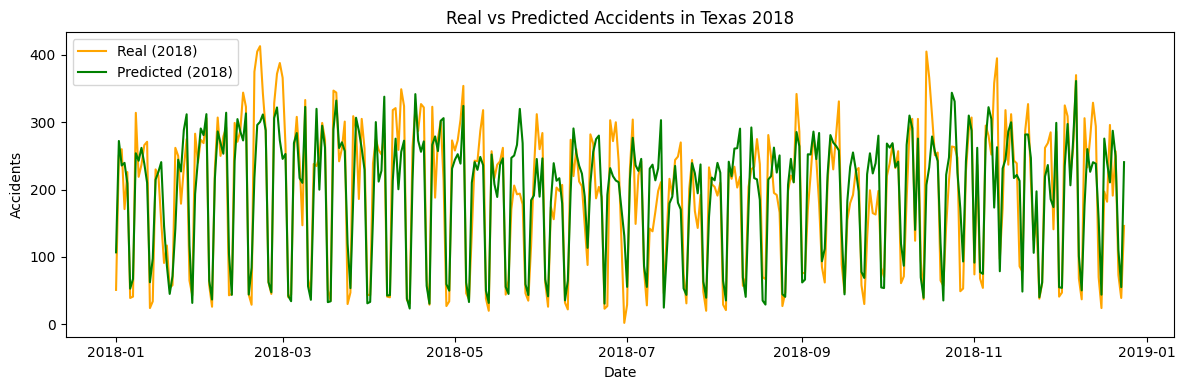

In [43]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date
import pandas as pd

# Ordenamos
df_Texas_dates_18 = df_Texas_18.select("Date", "Accidents").orderBy("Date")

# Obtener los datos como listas
rows_Texas_18 = df_Texas_dates_18.collect()
dates_Texas_18 = [row["Date"] for row in rows_Texas_18]
real_accidents_Texas_18 = [row["Accidents"] for row in rows_Texas_18]

# -------------------------------------------------

# Validar que las predicciones coincidan en longitud
if len(real_accidents_Texas_18) != len(y_pred):
    # Truncar los valores reales y fechas a la longitud de y_pred
    dates_Texas_18 = dates_Texas_18[:len(y_pred)]
    real_accidents_Texas_18 = real_accidents_Texas_18[:len(y_pred)]

# Graficar los resultados
plt.figure(figsize=(12, 4))
plt.plot(dates_Texas_18, real_accidents_Texas_18, label="Real (2018)", color="orange")
plt.plot(dates_Texas_18, y_pred, label="Predicted (2018)", color="green")
plt.title("Real vs Predicted Accidents in Texas 2018")
plt.xlabel("Date")
plt.ylabel("Accidents")
plt.legend()
plt.tight_layout()
plt.show()

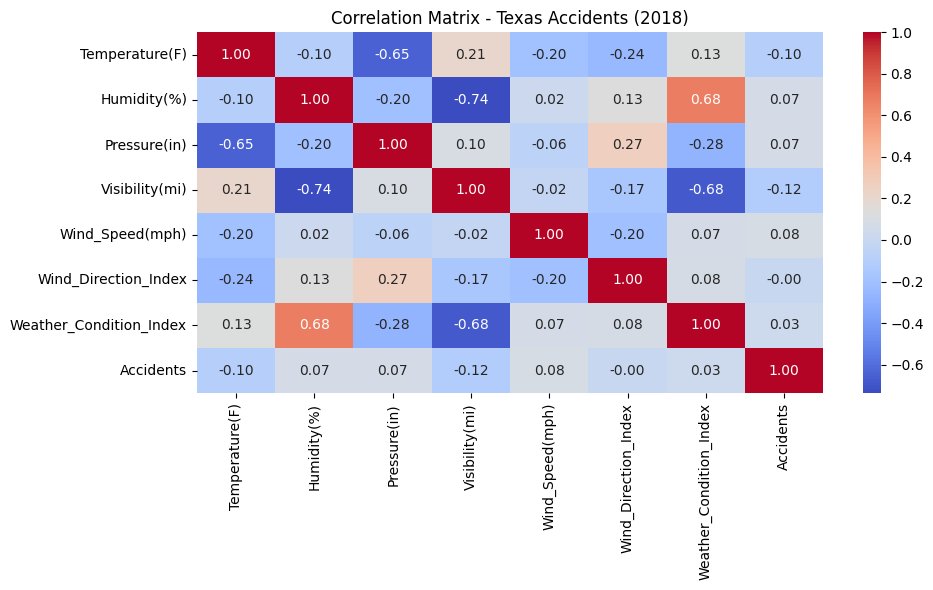

In [44]:
from pyspark.sql import SparkSession
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que ya tienes df_countrywise_18
selected_columns = ["Temperature(F)", "Humidity(%)", "Pressure(in)",
                    "Visibility(mi)", "Wind_Speed(mph)", "Wind_Direction_Index", "Weather_Condition_Index", "Accidents"]

# Convertir a pandas
pdf = df_Texas_18.select(selected_columns).toPandas()

# Calcular matriz de correlación
corr_matrix = pdf.corr()

# Visualizar con seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix - Texas Accidents (2018)")
plt.tight_layout()
plt.show()

Ahora Florida

In [45]:
#Ordenamos
df_Florida = df_Florida.orderBy("Date")

#Hacemos el conteo de accidentes diarios
accidents_per_day = df_Florida.groupBy("Date").count().withColumnRenamed("count", "Accidents")
df_Florida = df_Florida.join(accidents_per_day, on="Date", how="left")

#Promediamos las columnas numericas
df_Florida = df_Florida.groupBy("Date").agg(
    avg("Temperature(F)").alias("Temperature(F)"),
    avg("Humidity(%)").alias("Humidity(%)"),
    avg("Pressure(in)").alias("Pressure(in)"),
    avg("Visibility(mi)").alias("Visibility(mi)"),
    avg("Wind_Speed(mph)").alias("Wind_Speed(mph)"),
    avg("Wind_Direction_Index").alias("Wind_Direction_Index"),
    avg("Weather_Condition_Index").alias("Weather_Condition_Index"),
    avg("Accidents").alias("Accidents")
)
df_Florida = df_Florida.orderBy("Date")

# DataFrame para 2016 y 2017
df_Florida_16_17 = df_Florida.filter(year("Date").isin([2016, 2017]))

# DataFrame para 2018
df_Florida_18 = df_Florida.filter(year("Date") == 2018)

#Sacamos las particiones de train y test
# Creando X_train y Y_train sin Pandas

# Seleccionamos solo las columnas necesarias y las pasamos a numpy
selected_cols = ["Temperature(F)", "Humidity(%)", "Pressure(in)",
                 "Visibility(mi)", "Wind_Speed(mph)", "Wind_Direction_Index", "Weather_Condition_Index", "Accidents"]

df_ordered_train = df_Florida_16_17.orderBy("Date")
df_ordered_test = df_Florida_18.orderBy("Date")

# Convertimos a un NumPy array (ordenado previamente)
data_train_np = np.array(df_ordered_train.select(selected_cols).collect())
data_test_np = np.array(df_ordered_test.select(selected_cols).collect())

# Ventana deslizante
#Train
X_train = []
Y_train = []
dias = 7

for i in range(len(data_train_np) - dias):
    X_train.append(data_train_np[i:i+dias])       # 7 días de features
    Y_train.append(data_train_np[i+dias, -1])     # accidentes del día siguiente

X_train = np.array(X_train)  # shape: (num_samples, 7, 7)
Y_train = np.array(Y_train)  # shape: (num_samples,)

#Test
X_test = []
Y_test = []
dias = 7

for i in range(len(data_test_np) - dias):
    X_test.append(data_test_np[i:i+dias])       # 7 días de features
    Y_test.append(data_test_np[i+dias, -1])

X_test  = np.array(X_test)  # shape: (num_samples, 7, 7)
Y_test  = np.array(Y_test)  # shape: (num_samples,)

In [46]:
print("Datos para train: ", X_train.shape, Y_train.shape)
print("Datos para test: ", X_test.shape, Y_test.shape)

Datos para train:  (553, 7, 8) (553,)
Datos para test:  (358, 7, 8) (358,)


In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

model_Florida = xgb.XGBRegressor()
model_Florida.fit(X_train_flat, Y_train)

y_pred = model_Florida.predict(X_test_flat)

mse = mean_squared_error(Y_test, y_pred)
mae = mean_absolute_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

MSE: 3032.02
MAE: 36.83
R²: 0.55


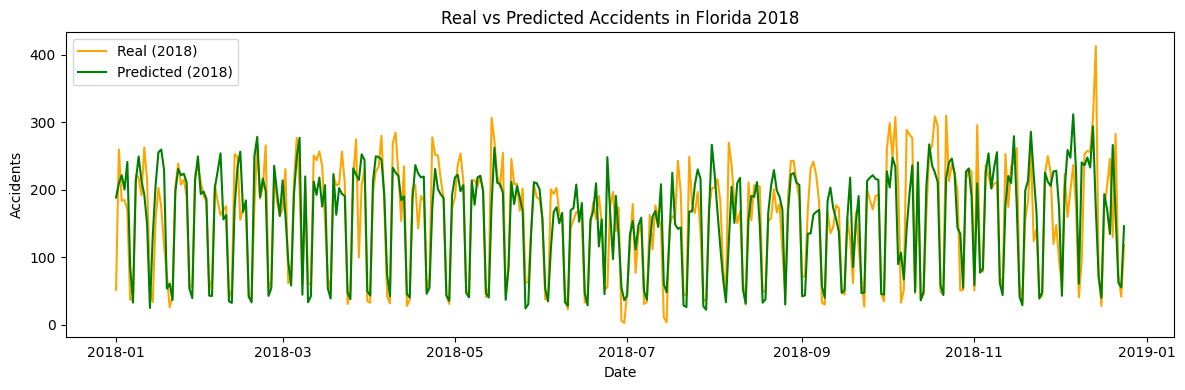

In [48]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date
import pandas as pd

# Ordenamos
df_Florida_dates_18 = df_Florida_18.select("Date", "Accidents").orderBy("Date")

# Obtener los datos como listas
rows_Florida_18 = df_Florida_dates_18.collect()
dates_Florida_18 = [row["Date"] for row in rows_Florida_18]
real_accidents_Florida_18 = [row["Accidents"] for row in rows_Florida_18]

# -------------------------------------------------

# Validar que las predicciones coincidan en longitud
if len(real_accidents_Florida_18) != len(y_pred):
    # Truncar los valores reales y fechas a la longitud de y_pred
    dates_Florida_18 = dates_Florida_18[:len(y_pred)]
    real_accidents_Florida_18 = real_accidents_Florida_18[:len(y_pred)]

# Graficar los resultados
plt.figure(figsize=(12, 4))
plt.plot(dates_Florida_18, real_accidents_Florida_18, label="Real (2018)", color="orange")
plt.plot(dates_Florida_18, y_pred, label="Predicted (2018)", color="green")
plt.title("Real vs Predicted Accidents in Florida 2018")
plt.xlabel("Date")
plt.ylabel("Accidents")
plt.legend()
plt.tight_layout()
plt.show()

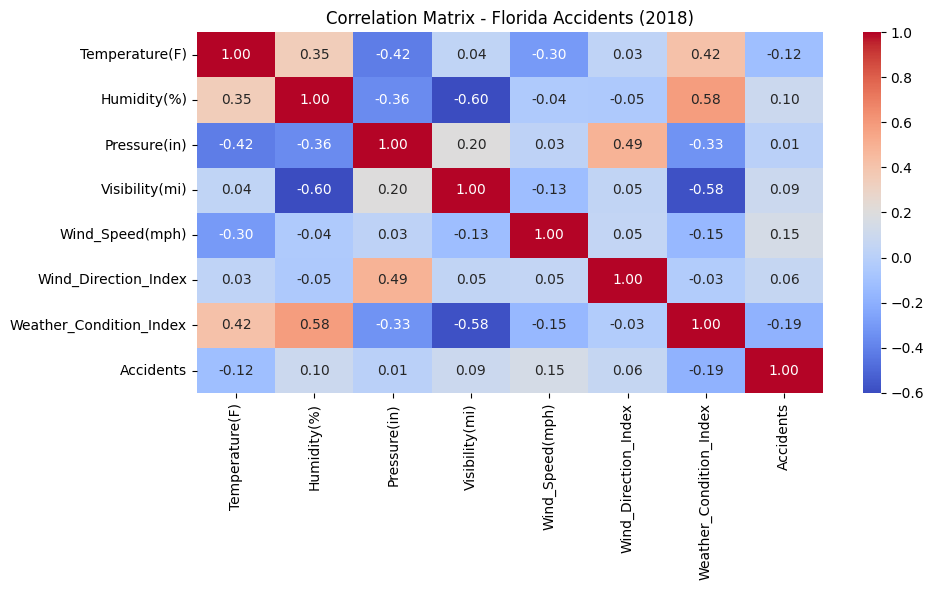

In [49]:
from pyspark.sql import SparkSession
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que ya tienes df_countrywise_18
selected_columns = ["Temperature(F)", "Humidity(%)", "Pressure(in)",
                    "Visibility(mi)", "Wind_Speed(mph)", "Wind_Direction_Index", "Weather_Condition_Index", "Accidents"]

# Convertir a pandas
pdf = df_Florida_18.select(selected_columns).toPandas()

# Calcular matriz de correlación
corr_matrix = pdf.corr()

# Visualizar con seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix - Florida Accidents (2018)")
plt.tight_layout()
plt.show()

Ahora New York

In [50]:
#Ordenamos
df_New_York = df_New_York.orderBy("Date")

#Hacemos el conteo de accidentes diarios
accidents_per_day = df_New_York.groupBy("Date").count().withColumnRenamed("count", "Accidents")
df_New_York = df_New_York.join(accidents_per_day, on="Date", how="left")

#Promediamos las columnas numericas
df_New_York = df_New_York.groupBy("Date").agg(
    avg("Temperature(F)").alias("Temperature(F)"),
    avg("Humidity(%)").alias("Humidity(%)"),
    avg("Pressure(in)").alias("Pressure(in)"),
    avg("Visibility(mi)").alias("Visibility(mi)"),
    avg("Wind_Speed(mph)").alias("Wind_Speed(mph)"),
    avg("Wind_Direction_Index").alias("Wind_Direction_Index"),
    avg("Weather_Condition_Index").alias("Weather_Condition_Index"),
    avg("Accidents").alias("Accidents")
)
df_New_York = df_New_York.orderBy("Date")

# DataFrame para 2016 y 2017
df_New_York_16_17 = df_New_York.filter(year("Date").isin([2016, 2017]))

# DataFrame para 2018
df_New_York_18 = df_New_York.filter(year("Date") == 2018)

#Sacamos las particiones de train y test
# Creando X_train y Y_train sin Pandas

# Seleccionamos solo las columnas necesarias y las pasamos a numpy
selected_cols = ["Temperature(F)", "Humidity(%)", "Pressure(in)",
                 "Visibility(mi)", "Wind_Speed(mph)", "Wind_Direction_Index", "Weather_Condition_Index", "Accidents"]

df_ordered_train = df_New_York_16_17.orderBy("Date")
df_ordered_test = df_New_York_18.orderBy("Date")

# Convertimos a un NumPy array (ordenado previamente)
data_train_np = np.array(df_ordered_train.select(selected_cols).collect())
data_test_np = np.array(df_ordered_test.select(selected_cols).collect())

# Ventana deslizante
#Train
X_train = []
Y_train = []
dias = 7

for i in range(len(data_train_np) - dias):
    X_train.append(data_train_np[i:i+dias])       # 7 días de features
    Y_train.append(data_train_np[i+dias, -1])     # accidentes del día siguiente

X_train = np.array(X_train)  # shape: (num_samples, 7, 7)
Y_train = np.array(Y_train)  # shape: (num_samples,)

#Test
X_test = []
Y_test = []
dias = 7

for i in range(len(data_test_np) - dias):
    X_test.append(data_test_np[i:i+dias])       # 7 días de features
    Y_test.append(data_test_np[i+dias, -1])

X_test  = np.array(X_test)  # shape: (num_samples, 7, 7)
Y_test  = np.array(Y_test)  # shape: (num_samples,)

In [51]:
print("Datos para train: ", X_train.shape, Y_train.shape)
print("Datos para test: ", X_test.shape, Y_test.shape)

Datos para train:  (631, 7, 8) (631,)
Datos para test:  (355, 7, 8) (355,)


In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

model_NewYork = xgb.XGBRegressor()
model_NewYork.fit(X_train_flat, Y_train)

y_pred = model_NewYork.predict(X_test_flat)

mse = mean_squared_error(Y_test, y_pred)
mae = mean_absolute_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

MSE: 1217.64
MAE: 23.68
R²: 0.44


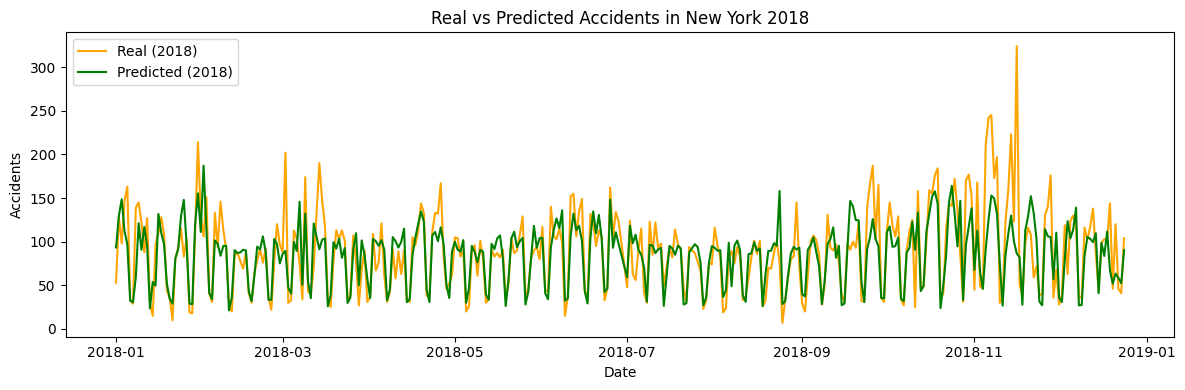

In [53]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date
import pandas as pd

# Ordenamos
df_New_York_dates_18 = df_New_York_18.select("Date", "Accidents").orderBy("Date")

# Obtener los datos como listas
rows_New_York_18 = df_New_York_dates_18.collect()
dates_New_York_18 = [row["Date"] for row in rows_New_York_18]
real_accidents_New_York_18 = [row["Accidents"] for row in rows_New_York_18]

# -------------------------------------------------

# Validar que las predicciones coincidan en longitud
if len(real_accidents_New_York_18) != len(y_pred):
    # Truncar los valores reales y fechas a la longitud de y_pred
    dates_New_York_18 = dates_New_York_18[:len(y_pred)]
    real_accidents_New_York_18 = real_accidents_New_York_18[:len(y_pred)]

# Graficar los resultados
plt.figure(figsize=(12, 4))
plt.plot(dates_New_York_18, real_accidents_New_York_18, label="Real (2018)", color="orange")
plt.plot(dates_New_York_18, y_pred, label="Predicted (2018)", color="green")
plt.title("Real vs Predicted Accidents in New York 2018")
plt.xlabel("Date")
plt.ylabel("Accidents")
plt.legend()
plt.tight_layout()
plt.show()

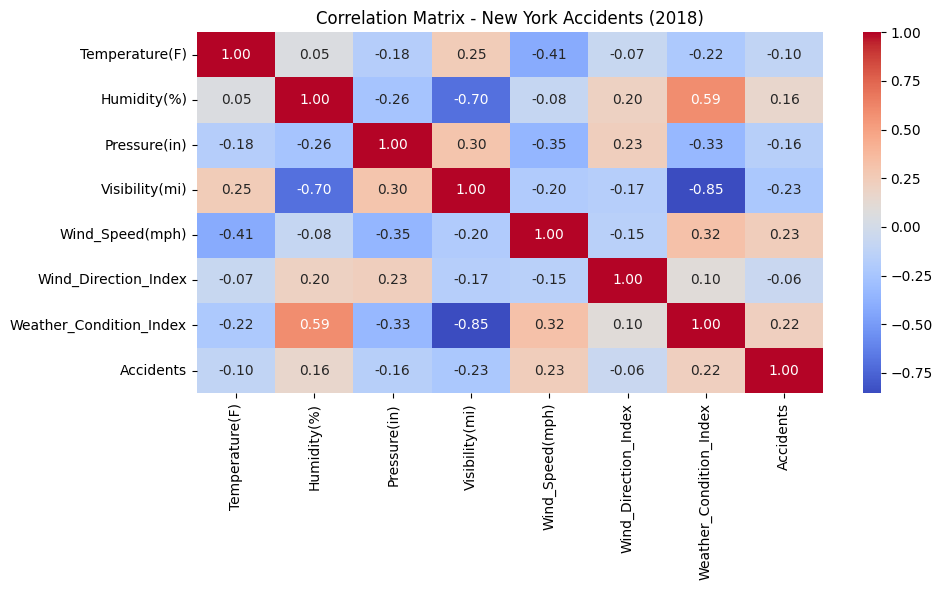

In [54]:
from pyspark.sql import SparkSession
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que ya tienes df_countrywise_18
selected_columns = ["Temperature(F)", "Humidity(%)", "Pressure(in)",
                    "Visibility(mi)", "Wind_Speed(mph)", "Wind_Direction_Index", "Weather_Condition_Index", "Accidents"]

# Convertir a pandas
pdf = df_New_York_18.select(selected_columns).toPandas()

# Calcular matriz de correlación
corr_matrix = pdf.corr()

# Visualizar con seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix - New York Accidents (2018)")
plt.tight_layout()
plt.show()

Ahora Pensilvania

In [55]:
#Ordenamos
df_Penny = df_Penny.orderBy("Date")

#Hacemos el conteo de accidentes diarios
accidents_per_day = df_Penny.groupBy("Date").count().withColumnRenamed("count", "Accidents")
df_Penny = df_Penny.join(accidents_per_day, on="Date", how="left")

#Promediamos las columnas numericas
df_Penny = df_Penny.groupBy("Date").agg(
    avg("Temperature(F)").alias("Temperature(F)"),
    avg("Humidity(%)").alias("Humidity(%)"),
    avg("Pressure(in)").alias("Pressure(in)"),
    avg("Visibility(mi)").alias("Visibility(mi)"),
    avg("Wind_Speed(mph)").alias("Wind_Speed(mph)"),
    avg("Wind_Direction_Index").alias("Wind_Direction_Index"),
    avg("Weather_Condition_Index").alias("Weather_Condition_Index"),
    avg("Accidents").alias("Accidents")
)
df_Penny = df_Penny.orderBy("Date")

# DataFrame para 2016 y 2017
df_Penny_16_17 = df_Penny.filter(year("Date").isin([2016, 2017]))

# DataFrame para 2018
df_Penny_18 = df_Penny.filter(year("Date") == 2018)

#Sacamos las particiones de train y test
# Creando X_train y Y_train sin Pandas

# Seleccionamos solo las columnas necesarias y las pasamos a numpy
selected_cols = ["Temperature(F)", "Humidity(%)", "Pressure(in)",
                 "Visibility(mi)", "Wind_Speed(mph)", "Wind_Direction_Index", "Weather_Condition_Index", "Accidents"]

df_ordered_train = df_Penny_16_17.orderBy("Date")
df_ordered_test = df_Penny_18.orderBy("Date")

# Convertimos a un NumPy array (ordenado previamente)
data_train_np = np.array(df_ordered_train.select(selected_cols).collect())
data_test_np = np.array(df_ordered_test.select(selected_cols).collect())

# Ventana deslizante
#Train
X_train = []
Y_train = []
dias = 7

for i in range(len(data_train_np) - dias):
    X_train.append(data_train_np[i:i+dias])       # 7 días de features
    Y_train.append(data_train_np[i+dias, -1])     # accidentes del día siguiente

X_train = np.array(X_train)  # shape: (num_samples, 7, 7)
Y_train = np.array(Y_train)  # shape: (num_samples,)

#Test
X_test = []
Y_test = []
dias = 7

for i in range(len(data_test_np) - dias):
    X_test.append(data_test_np[i:i+dias])       # 7 días de features
    Y_test.append(data_test_np[i+dias, -1])

X_test  = np.array(X_test)  # shape: (num_samples, 7, 7)
Y_test  = np.array(Y_test)  # shape: (num_samples,)

In [56]:
print("Datos para train: ", X_train.shape, Y_train.shape)
print("Datos para test: ", X_test.shape, Y_test.shape)

Datos para train:  (654, 7, 8) (654,)
Datos para test:  (356, 7, 8) (356,)


In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

model_Penny = xgb.XGBRegressor()
model_Penny.fit(X_train_flat, Y_train)

y_pred = model_Penny.predict(X_test_flat)

mse = mean_squared_error(Y_test, y_pred)
mae = mean_absolute_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

MSE: 740.30
MAE: 21.31
R²: 0.08


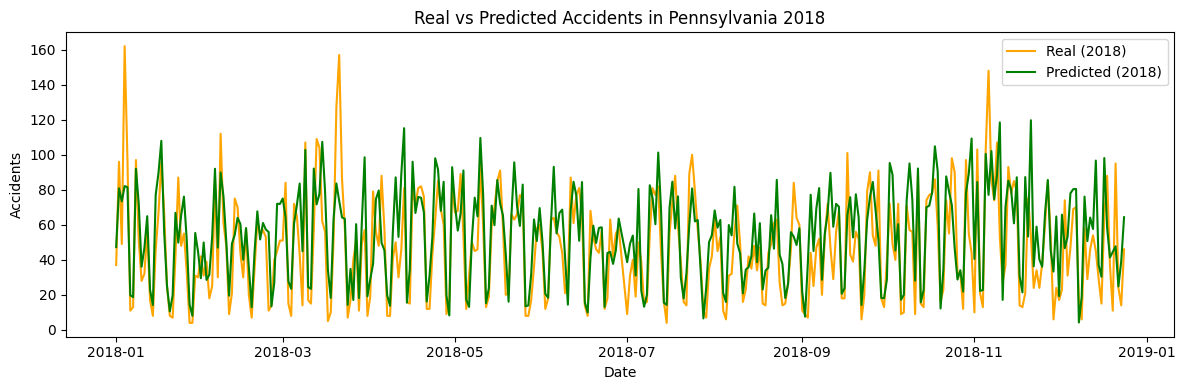

In [58]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date
import pandas as pd

# Ordenamos
df_Penny_dates_18 = df_Penny_18.select("Date", "Accidents").orderBy("Date")

# Obtener los datos como listas
rows_Penny_18 = df_Penny_dates_18.collect()
dates_Penny_18 = [row["Date"] for row in rows_Penny_18]
real_accidents_Penny_18 = [row["Accidents"] for row in rows_Penny_18]

# -------------------------------------------------

# Validar que las predicciones coincidan en longitud
if len(real_accidents_Penny_18) != len(y_pred):
    # Truncar los valores reales y fechas a la longitud de y_pred
    dates_Penny_18 = dates_Penny_18[:len(y_pred)]
    real_accidents_Penny_18 = real_accidents_Penny_18[:len(y_pred)]

# Graficar los resultados
plt.figure(figsize=(12, 4))
plt.plot(dates_Penny_18, real_accidents_Penny_18, label="Real (2018)", color="orange")
plt.plot(dates_Penny_18, y_pred, label="Predicted (2018)", color="green")
plt.title("Real vs Predicted Accidents in Pennsylvania 2018")
plt.xlabel("Date")
plt.ylabel("Accidents")
plt.legend()
plt.tight_layout()
plt.show()

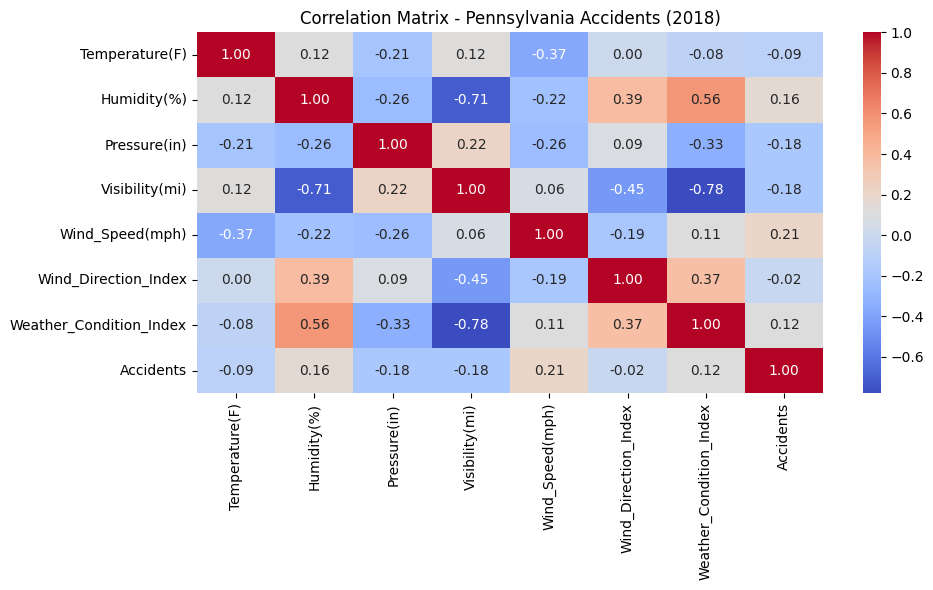

In [59]:
from pyspark.sql import SparkSession
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que ya tienes df_countrywise_18
selected_columns = ["Temperature(F)", "Humidity(%)", "Pressure(in)",
                    "Visibility(mi)", "Wind_Speed(mph)", "Wind_Direction_Index", "Weather_Condition_Index", "Accidents"]

# Convertir a pandas
pdf = df_Penny_18.select(selected_columns).toPandas()

# Calcular matriz de correlación
corr_matrix = pdf.corr()

# Visualizar con seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix - Pennsylvania Accidents (2018)")
plt.tight_layout()
plt.show()